<a href="https://colab.research.google.com/github/govind17/Information-Retrieval-Project/blob/main/LDA_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -U Flask
!pip install git+https://github.com/boudinfl/pke.git
!pip install matplotlib
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 101 kB 3.7 MB/s ta 0:00:01
  Attempting uninstall: Flask
    Found existing installation: Flask 2.2.2
    Uninstalling Flask-2.2.2:
      Successfully uninstalled Flask-2.2.2
  Cloning https://github.com/boudinfl/pke.git to /private/var/folders/2f/415rt6t93f15z4j0lsvsxzxc0000gn/T/pip-req-build-i_jkc2m2
  Running command git clone -q https://github.com/boudinfl/pke.git /private/var/folders/2f/415rt6t93f15z4j0lsvsxzxc0000gn/T/pip-req-build-i_jkc2m2
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
     |████████████████████████████████| 12.8 MB 6.1 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/GovindShukla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/GovindShukla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# One time installation
!pip install gensim
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [35]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import numpy as np
import pandas as pd
import operator
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize

import flask
from flask import request
from flask_cors import CORS
from flask import Flask, Response
from keyPhrasification import key_phrasification

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from io import BytesIO

import pyterrier as pt
import os

In [2]:
# Indexing the cord-19 dataset
if not pt.started():
    pt.init()

cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = 'C:/Users/Pritha/Desktop/SUBJECTS/PROJECT/Relevance feedback with XAI/Backend Code/Information-Retrieval-Project/terrier_cord19'
if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer
    indexer = pt.index.IterDictIndexer(pt_index_path)
    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = indexer.index(cord19.get_corpus_iter(),
                              fields=('abstract',),
                              meta=('docno',))
else:
    # if you already have the index, use it.
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
    index = pt.IndexFactory.of(index_ref)


NameError: name 'pt' is not defined

In [3]:
# Rocchio algorithm
def rocchio_algorithm(query_doc_vector, docs_relevant_vectors,
                      docs_irrelevant_vectors, key_relevant_vectors,
                      key_irrelevant_vectors,
                      alpha, beta, gamma, delta):

    # sum_of_rel_doc_vectors = docs_relevant_vectors.sum(axis=0)
    # print('sum_of_rel_doc_vectors', sum_of_rel_doc_vectors)
    sum_of_rel_doc_vectors=[]
    sum_of_irrel_doc_vectors=[]
    sum_of_rel_key_vectors=[]
    sum_of_irrel_key_vectors=[]
    for each_rel_doc_vector in docs_relevant_vectors:
        if len(sum_of_rel_doc_vectors) == 0:
            print('Length of sum_of_rel_doc_vectors is zero')
            sum_of_rel_doc_vectors = each_rel_doc_vector
        else:
            # print(each_rel_doc_vector)
            sum_of_rel_doc_vectors = list(map(operator.add, sum_of_rel_doc_vectors, each_rel_doc_vector))
            # print('SUM :', sum_of_rel_doc_vectors)
    for each_irrel_doc_vector in docs_irrelevant_vectors:
        if len(sum_of_irrel_doc_vectors) == 0:
            print('Length of sum_of_irrel_doc_vectors is zero')
            sum_of_irrel_doc_vectors = each_irrel_doc_vector
        else:
            sum_of_irrel_doc_vectors = list(map(operator.add, sum_of_irrel_doc_vectors, each_irrel_doc_vector))
    # sum_of_irrel_doc_vectors = docs_irrelevant_vectors.sum(axis=0)
    # print('sum_of_irrel_doc_vectors', sum_of_irrel_doc_vectors)
    for each_rel_key_vector in key_relevant_vectors:
        if len(sum_of_rel_key_vectors) == 0:
            print('Length of sum_of_rel_key_vectors is zero')
            sum_of_rel_key_vectors = each_rel_key_vector
        else:
            sum_of_rel_key_vectors = list(map(operator.add, sum_of_rel_key_vectors, each_rel_key_vector))
    # sum_of_rel_key_vectors = key_relevant_vectors.sum(axis=0)
    # print('sum_of_rel_key_vectors', sum_of_rel_key_vectors)
    for each_irrel_key_vector in key_irrelevant_vectors:
        if len(sum_of_irrel_key_vectors) == 0:
            print('Length of sum_of_irrel_key_vectors is zero')
            sum_of_irrel_key_vectors = each_irrel_key_vector
        else:
            sum_of_irrel_key_vectors = list(map(operator.add, sum_of_irrel_key_vectors, each_irrel_key_vector))
    # sum_of_irrel_key_vectors = key_irrelevant_vectors.sum(axis=0)
    # print('sum_of_irrel_key_vectors', (delta/len(docs_relevant_vectors)) * np.array(sum_of_irrel_key_vectors))

    new_doc_vector_query = np.sum([np.array(query_doc_vector)
    , (alpha/len(docs_relevant_vectors)) * np.array(sum_of_rel_doc_vectors)
    , (beta/len(docs_irrelevant_vectors)) * np.array(sum_of_irrel_doc_vectors)
    , (gamma/len(docs_relevant_vectors)) * np.array(sum_of_rel_key_vectors)
    , (delta/len(docs_relevant_vectors)) * np.array(sum_of_irrel_key_vectors)], axis=0)
    df = pd.DataFrame({"a": [new_doc_vector_query]})
    return df.values

# Compute cosine scores
def compute_cosine_sim(new_query_vector, all_data, name):
    consine_similarities = []
    for index, data in all_data.iterrows():
        cosine_sim = cosine_similarity([np.array(new_query_vector[0])], [np.array(all_data[name][index])])
        consine_similarities.append(cosine_sim[0][0])
    return consine_similarities

# Rank data
def rank_data(new_query_vector, dataset, name):
  cosine_sim_values = compute_cosine_sim(new_query_vector, dataset, name)
  dataset['Cosine_Similarity_' + name] = cosine_sim_values
  sorted_dataset = dataset.sort_values(by=['Cosine_Similarity_' + name], ascending=False)

  return sorted_dataset



In [4]:
#text preprocessing
def pre_processing_data(data):
    ps = PorterStemmer()
    tagged_dataset = [TaggedDocument(words=[ps.stem(w) for w in nltk.word_tokenize(_d) if word_tokenize(_d.lower()) not in stopwords.words('english')], tags=[str(i)]) for i, _d in enumerate(data)]
    #tagged_dataset = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
    return tagged_dataset

def model_doc2vec(model, tagged_data, num_epochs):
    model.build_vocab(tagged_data)
    model.train(tagged_data,total_examples=len(tagged_data), epochs=num_epochs)
    return model

def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, feature_vectors

def define_d2v_model(dataset):
    preprocessed_tagged_dataset = pre_processing_data(dataset)
    model_d2v = Doc2Vec(dm=1, vector_size=100, window = 10, negative=5, hs=0, min_count=2, sample = 0, alpha=0.025, min_alpha=0.001, dm_mean = 0, dbow_words=1)
    model = model_doc2vec(model_d2v, preprocessed_tagged_dataset, 100)
    return model

def get_vectors(input_data, model):
    preprocessed_tagged_input_data= pre_processing_data(input_data)
    id, vectors = np.array(vector_for_learning(model, preprocessed_tagged_input_data), dtype=object)
    return vectors

In [4]:
import pyterrier as pt
from pyterrier_t5 import MonoT5ReRanker
import pandas as pd
from keyPhrasification import key_phrasification

monoT5 = MonoT5ReRanker(text_field='abstract')
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
cord19_df = pd.read_csv('/Users/GovindShukla/Downloads/cord19_sum_key.csv')
model = define_d2v_model(cord19_df['abstract'])
query_df = pd.DataFrame
reranked_df = pd.DataFrame

def search_query(query):
  index_ref2 = pt.IndexRef.of(pt_index_path + "/data.properties")
  index2 = pt.IndexFactory.of(index_ref2)
  # print(query)
  if not pt.started():
      pt.init()
  br = pt.BatchRetrieve(index2) % 10
  pipeline = (br >> pt.text.get_text(dataset, 'abstract') >> monoT5)
  search_result = pipeline.search(query)
  print(search_result)
  filtered_docs = pd.merge(cord19_df, search_result, on = "docno", how = "inner")
  searchResultswithkeys = key_phrasification(filtered_docs)
  print(searchResultswithkeys)
  return filtered_docs

search_query('covid')

C:\Users\Pritha\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
monoT5: 100%|██████████| 3/3 [00:12<00:00,  4.19s/batches]


Index(['docno', 'title', 'abstract_x', 'summary', 'key_phrases', 'qid',
       'docid', 'query', 'abstract_y', 'score', 'rank'],
      dtype='object')
Index(['docno', 'title', 'abstract', 'summary', 'KeyList'], dtype='object')


















































      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of... 

,docno,title,abstract_x,summary,key_phrases,qid,docid,query,abstract_y,score,rank
0,awitk3se,COVID-19 (Novel Coronavirus 2019) - recent tre...,The World Health Organization (WHO) has issued...,COVID-19 is similar to Severe Acute Respirator...,NaN,1,32226,covid,The World Health Organization (WHO) has issued...,-0.161107,3
1,s4dqx9en,Plasma Metabolomic and Lipidomic Alterations A...,The pandemic of the coronavirus disease 2019 (...,COVID-19 is marked by its rapid progression fr...,NaN,1,68320,covid,The pandemic of the coronavirus disease 2019 (...,-0.267529,5
2,u56ydlve,The impact of believing you have had COVID-19 ...,Objectives: To investigate whether people who ...,The impact of believing you have had COVID-19 ...,NaN,1,75497,covid,Objectives: To investigate whether people who ...,-0.856843,9
3,3kmxzbm7,COVID-19 (Novel Coronavirus 2019) - recent trends,The World Health Organization (WHO) has issued...,COVID-19 is similar to Severe Acute Respirator...,NaN,1,93863,covid,The World Health Organization (WHO) has issued...,-0.161107,4
4,l2rmmjqb,Validation of the British Society of Thoracic ...,AIM: To validate the British Society of Thorac...,Validation of the British Society of Thoracic ...,NaN,1,109749,covid,AIM: To validate the British Society of Thorac...,-0.333039,6
5,zub7xdi9,Comparison of the computed tomography findings...,OBJECTIVES: To compare the chest computed tomo...,Comparison of the computed tomography findings...,NaN,1,112383,covid,OBJECTIVES: To compare the chest computed tomo...,-0.085978,0
6,rxd08ouk,"Cognitive, Affective, and Behavioral Construct...",This online survey study aimed to compare the ...,"In total, 533 sexual minority and 1421 heteros...",NaN,1,126243,covid,This online survey study aimed to compare the ...,-0.112808,1
7,448tamvr,Validation of the British Society of Thoracic ...,Abstract Aim To validate the British Society o...,Validation of the British Society of Thoracic ...,NaN,1,150199,covid,Abstract Aim To validate the British Society o...,-0.480262,7
8,eyelcflh,"Cognitive, Affective, and Behavioral Construct...",This online survey study aimed to compare the ...,"In total, 533 sexual minority and 1421 heteros...",NaN,1,153035,covid,This online survey study aimed to compare the ...,-0.112808,2
9,1loqavom,Stability Analysis and Numerical Simulation of...,The Aim of this research is construct the SEIR...,Stability Analysis and Numerical Simulation of...,NaN,1,171671,covid,The Aim of this research is construct the SEIR...,-0.639952,8


In [14]:
cord19_df = pd.read_csv('/Users/GovindShukla/Downloads/cord19_sum_key.csv')

model = define_d2v_model(cord19_df[~cord19_df['abstract'].isna()]['abstract'])

In [15]:
import joblib
#
# # Save the model as a pickle in a file
# joblib.dump(model, 'gensim_model_2.pkl')
model = joblib.load('/Users/GovindShukla/Desktop/Information-Retrieval-Project/gensim_model_2.pkl')

['gensim_model_2.pkl']

In [17]:
def get_reranking(feedback_df : pd.DataFrame):
    global  query_df
    global reranked_df
    feedback_df["summary_vec"] = get_vectors(feedback_df['summary'], model)
    feedback_df["keyList_vec"] = get_vectors(feedback_df['KeyList'], model)
    relevant_df = feedback_df.loc[feedback_df['relevant'] == True]
    irrelevant_df = feedback_df.loc[feedback_df['relevant'] == False]
    query_df["query_vec"]  = get_vectors(query_df['query'].values, model)
    query_df['new_query_vec'] = rocchio_algorithm(query_df["query_vec"][0], relevant_df["summary_vec"].values, irrelevant_df["summary_vec"].values, relevant_df["keyList_vec"].values, irrelevant_df["keyList_vec"].values, 1.0, 0.5,1.0, 0.5)
    sorted_dataset = rank_data(query_df['new_query_vec'].values, feedback_df, "keyList_vec")
    return sorted_dataset

def generate_plot():
    rel_docs = []
    irrel_docs = []
    for i, data in enumerate(reranked_df.loc[reranked_df['relevant'] == True]['summary_vec'].values):
        rel_docs.append(data)
    for i, data in enumerate(reranked_df.loc[reranked_df['relevant'] == False]['summary_vec'].values):
        irrel_docs.append(data)
    pca = PCA(n_components=2)
    pca_rel = pca.fit_transform(rel_docs)
    pca_irrel = pca.fit_transform(irrel_docs)

    query =np.concatenate(([np.array(query_df.iloc[0]['query_vec'])], [np.array(query_df.iloc[0]['new_query_vec'])]), axis=0)
    pca_query = pca.fit_transform(query)

    plt.scatter(pca_rel[:,0], pca_rel[:,1], marker=".", label="rel_doc")
    plt.scatter(pca_irrel[:,0], pca_irrel[:,1], marker="*", label="irrel_doc")
    plt.scatter(pca_query[0][0], pca_query[0][1], marker="s", label="old_query")
    plt.scatter(pca_query[1][0], pca_query[1][1], marker="s", label="new_query")
    plt.legend()
    return plt

In [325]:

app = flask.Flask(__name__)

# app.config["DEBUG"] = True
CORS(app)

@app.route('/query', methods=['GET'])
def search():
    query = request.args.get('searchString')
    print(query)
    searchResults = search_query(query)
    print(searchResults.head())
    searchResultswithkeys = key_phrasification(searchResults)

    global query_df
    query_dict = {'query': [query], 'query_vec' : [np.nan], 'new_query_vec' : [np.nan] }
    query_df = pd.DataFrame(data=query_dict, index=[0])
    print(searchResultswithkeys)
    return searchResultswithkeys.to_json(orient='records')

# Feedback
@app.route('/feedback', methods=['POST'])
def fetchFeedback():
    feedbackJson = request.json['updates']
    relevanceList = []
    if len(feedbackJson):
        for doc in feedbackJson:
            for relevance in doc['value']:
                relevanceList.append(relevance)
    feedback_df = pd.DataFrame(relevanceList)
    feedback_df.drop(columns=['bntStyle'], inplace=True)
    reranked_df = get_reranking(feedback_df)
    return reranked_df.to_json(orient='records')

@app.route('/plot')
def plot():
    # Generate the plot
    fig = generate_plot()
    buffer = BytesIO()
    fig.savefig(buffer, format='png')
    buffer.seek(0)

    # Return the image as a Flask response
    return Response(buffer.getvalue(), mimetype='image/png')

if __name__ == "__main__":

    app.run(host='0.0.0.0',port=5030)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5030
 * Running on http://192.168.0.100:5030
Press CTRL+C to quit
127.0.0.1 - - [12/Mar/2023 13:17:57] "GET /query?searchString=ndblkdj HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:18:09] "OPTIONS /feedback HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2023 13:18:10] "POST /feedback HTTP/1.1" 200 -


Length of sum_of_rel_doc_vectors is zero
Length of sum_of_irrel_doc_vectors is zero
Length of sum_of_rel_key_vectors is zero
Length of sum_of_irrel_key_vectors is zero


127.0.0.1 - - [12/Mar/2023 13:19:00] "GET /query?searchString=knkj HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:19:02] "GET /query?searchString=knkj HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:19:02] "GET /query?searchString=knkj HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2023 13:19:03] "GET /query?searchString=knkj HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:19:03] "GET /query?searchString=knkj HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2023 13:19:03] "GET /query?searchString=knkj HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:19:03] "GET /query?searchString=knkj HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:19:12] "GET /query?searchString=covid19 HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:20:38] "OPTIONS /feedback HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2023 13:20:39] "POST /feedback HTTP/1.1" 200 -


Length of sum_of_rel_doc_vectors is zero
Length of sum_of_irrel_doc_vectors is zero
Length of sum_of_rel_key_vectors is zero
Length of sum_of_irrel_key_vectors is zero


127.0.0.1 - - [12/Mar/2023 13:20:53] "GET /query?searchString=Covid19 HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:21:20] "OPTIONS /feedback HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2023 13:21:20] "POST /feedback HTTP/1.1" 200 -


Length of sum_of_rel_doc_vectors is zero
Length of sum_of_irrel_doc_vectors is zero
Length of sum_of_rel_key_vectors is zero
Length of sum_of_irrel_key_vectors is zero


127.0.0.1 - - [12/Mar/2023 13:22:33] "GET /query?searchString=kjhljkh HTTP/1.1" 200 -


      docno                                              title  \
0  awitk3se  COVID-19 (Novel Coronavirus 2019) - recent tre...   
1  s4dqx9en  Plasma Metabolomic and Lipidomic Alterations A...   
2  u56ydlve  The impact of believing you have had COVID-19 ...   
3  3kmxzbm7  COVID-19 (Novel Coronavirus 2019) - recent trends   
4  l2rmmjqb  Validation of the British Society of Thoracic ...   
5  zub7xdi9  Comparison of the computed tomography findings...   
6  rxd08ouk  Cognitive, Affective, and Behavioral Construct...   
7  448tamvr  Validation of the British Society of Thoracic ...   
8  eyelcflh  Cognitive, Affective, and Behavioral Construct...   
9  1loqavom  Stability Analysis and Numerical Simulation of...   

                                            abstract  \
0  The World Health Organization (WHO) has issued...   
1  The pandemic of the coronavirus disease 2019 (...   
2  Objectives: To investigate whether people who ...   
3  The World Health Organization (WHO) has issued

127.0.0.1 - - [12/Mar/2023 13:23:03] "OPTIONS /feedback HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2023 13:23:04] "POST /feedback HTTP/1.1" 200 -


Length of sum_of_rel_doc_vectors is zero
Length of sum_of_irrel_doc_vectors is zero
Length of sum_of_rel_key_vectors is zero
Length of sum_of_irrel_key_vectors is zero


###Feedback

0       OBJECTIVE: This retrospective chart review des...
1       Inflammatory diseases of the respiratory tract...
2       Surfactant protein-D (SP-D) participates in th...
3       Endothelin-1 (ET-1) is a 21 amino acid peptide...
4       Respiratory syncytial virus (RSV) and pneumoni...
                              ...                        
996     In a paper appearing in this issue, Adini, et ...
997     Hemophagocytic lymphohistiocytosis is a potent...
998     BACKGROUND: Critical illness due to 2009 H1N1 ...
999     BACKGROUND: The gp90 protein of avian reticulo...
1000    Human metapneumovirus (hMPV) is emerging as a ...
Name: abstract, Length: 957, dtype: object

In [337]:
def get_reranking(feedback_df : pd.DataFrame, model):
    global  query_df
    feedback_df["summary_vec"] = get_vectors(feedback_df['summary'], model)
    feedback_df["keyList_vec"] = get_vectors(feedback_df['KeyList'], model)
    relevant_df = feedback_df.loc[feedback_df['relevant'] == True]
    irrelevant_df = feedback_df.loc[feedback_df['relevant'] == False]
    query_df["query_vec"]  = get_vectors(query_df['query'].values, model)
    query_df['new_query_vec'] = rocchio_algorithm(query_df["query_vec"][0], relevant_df["summary_vec"].values, irrelevant_df["summary_vec"].values, relevant_df["keyList_vec"].values, irrelevant_df["keyList_vec"].values, 1.0, 0.5,1.0, 0.5)
    sorted_dataset = rank_data(query_df['new_query_vec'].values, feedback_df, "keyList_vec")
    return sorted_dataset

In [27]:
def cal_RM():
    data = pd.read_csv('/Users/GovindShukla/Desktop/Information-Retrieval-Project/search_result.csv')
    print(data['summary'])
    model = define_d2v_model(data['abstract'])
    q = {'query': ['Covid19'], 'query_vec' : [np.nan], 'new_query_vec' : [np.nan] }
    query_df = pd.DataFrame(data=q, index=[0])
    data["summary_vec"] = get_vectors(data['summary'], model)
    data["keyList_vec"] = get_vectors(data['KeyList'], model)
    query_df["query_vec"]  = get_vectors(query_df['query'].values, model)
    query_df['new_query_vec'] = rocchio_algorithm(query_df["query_vec"][0], data["summary_vec"].head(3).values, data["summary_vec"].head(7).values,
                      data["keyList_vec"].head(3).values, data["keyList_vec"].head(7).values, 1.0, 0.5,1.0, 0.5)
    sorted_dataset = rank_data(query_df['new_query_vec'].values, data, "keyList_vec")
    print(sorted_dataset['summary'])
cal_RM()

0    COVID-19 is similar to Severe Acute Respirator...
1    COVID-19 is marked by its rapid progression fr...
2    The impact of believing you have had COVID-19 ...
3    COVID-19 is similar to Severe Acute Respirator...
4    Validation of the British Society of Thoracic ...
5    Comparison of the computed tomography findings...
6    In total, 533 sexual minority and 1421 heteros...
7    Validation of the British Society of Thoracic ...
8    In total, 533 sexual minority and 1421 heteros...
9    Stability Analysis and Numerical Simulation of...
Name: summary, dtype: object
Length of sum_of_rel_doc_vectors is zero
Length of sum_of_irrel_doc_vectors is zero
Length of sum_of_rel_key_vectors is zero
Length of sum_of_irrel_key_vectors is zero
1    COVID-19 is marked by its rapid progression fr...
0    COVID-19 is similar to Severe Acute Respirator...
5    Comparison of the computed tomography findings...
3    COVID-19 is similar to Severe Acute Respirator...
2    The impact of believing you 

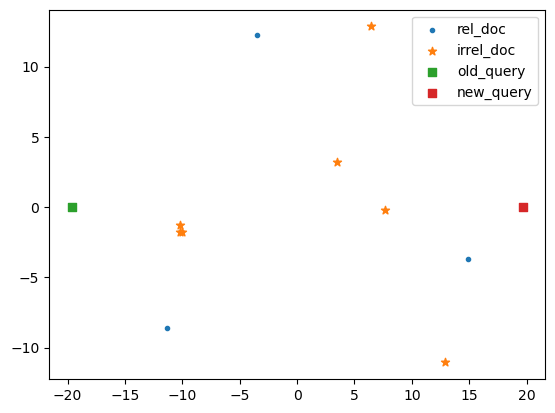